In [0]:
from keras import Model
from keras import layers
from matplotlib import pyplot
from keras.datasets import cifar100
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
from keras.models import load_model

In [0]:
def resnet_stem(x):
  x = layers.Conv2D(32, (3,3), activation='relu', padding = 'same')(x)
  x = layers.Conv2D(32, (3,3), activation='relu', padding = 'same')(x)
  x = layers.Conv2D(64, (3,3), activation='relu', padding = 'same')(x)
  x = layers.Conv2D(64, (1,1), activation='relu', padding = 'same')(x)
  x = layers.Conv2D(192, (3,3), activation='relu', padding = 'same')(x)
  x = layers.Conv2D(256, (3,3), activation='relu', padding = 'same')(x)
  x = layers.BatchNormalization()(x)

  return x

In [0]:
def moduleA(x, scale_residual=True):

  shortcut = x
  
  c1 = layers.Conv2D(32, (1,1), activation='relu', padding = 'same')(x)
  
  c2 = layers.Conv2D(32, (1,1), activation='relu', padding = 'same')(x)
  c2 = layers.Conv2D(32, (3,3), activation='relu', padding = 'same')(c2)

  c3 = layers.Conv2D(32, (1,1), activation='relu', padding = 'same')(x)
  c3 = layers.Conv2D(32, (3,3), activation='relu', padding = 'same')(c3)
  c3 = layers.Conv2D(32, (3,3), activation='relu', padding = 'same')(c3)

  concat = layers.concatenate([c1,c2,c3] , axis = -1)

  conv = layers.Conv2D(256, (1,1) , activation='linear', padding='same')(concat)
  
  if scale_residual: 
    conv = layers.Lambda(lambda x: x * 0.1)(conv)

  conv = layers.add([conv,shortcut])
  conv = layers.BatchNormalization()(conv)
  conv = layers.ReLU()(conv)

  return conv

In [0]:
def moduleB(x, scale_residual=True):

  shortcut = x
  
  c1 = layers.Conv2D(128, (1,1), activation='relu', padding = 'same')(x)
  
  c2 = layers.Conv2D(128, (1,1), activation='relu', padding = 'same')(x)
  c2 = layers.Conv2D(128, (1,7), activation='relu', padding = 'same')(c2)
  c2 = layers.Conv2D(128, (7,1), activation='relu', padding = 'same')(c2)

  concat = layers.concatenate([c1,c2] , axis = -1)

  conv = layers.Conv2D(896, (1,1) , activation='linear', padding='same')(concat)
  
  if scale_residual: 
    conv = layers.Lambda(lambda x: x * 0.1)(conv)

  conv = layers.add([conv,shortcut])
  conv = layers.BatchNormalization()(conv)
  conv = layers.ReLU()(conv)

  return conv

In [0]:
def moduleC(x, scale_residual=True):

  shortcut = x
  
  c1 = layers.Conv2D(192, (1,1), activation='relu', padding = 'same')(x)
  
  c2 = layers.Conv2D(192, (1,1), activation='relu', padding = 'same')(x)
  c2 = layers.Conv2D(192, (1,3), activation='relu', padding = 'same')(c2)
  c2 = layers.Conv2D(192, (3,1), activation='relu', padding = 'same')(c2)

  concat = layers.concatenate([c1,c2] , axis = -1)

  conv = layers.Conv2D(1792, (1,1) , activation='linear', padding='same')(concat)
  
  if scale_residual: 
    conv = layers.Lambda(lambda x: x * 0.1)(conv)

  conv = layers.add([conv,shortcut])
  conv = layers.BatchNormalization()(conv)
  conv = layers.ReLU()(conv)

  return conv

In [0]:
def reduction_A(x, k=192, l=192, m=256, n=384):

 p = layers.MaxPooling2D((3,3), strides = (2,2))(x)
 
 c1 = layers.Conv2D(n, (3,3), activation = 'relu', strides = (2,2))(x)

 c2 = layers.Conv2D(k, (1,1), activation = 'relu')(x)
 c2 = layers.Conv2D(l, (3,3), activation = 'relu', padding = 'same')(c2)
 c2 = layers.Conv2D(m, (3,3), activation = 'relu', strides = (2,2))(c2)

 m = layers.concatenate([p, c1,c2] , axis = -1)
 m = layers.BatchNormalization()(m)
 m = layers.ReLU()(m)

 return m

In [0]:
def reduction_B(x):

    c1 = layers.MaxPool2D((3,3), strides=(2,2), border_mode='valid')(x)

    c2 = layers.Conv2D(256, (1,1), activation='relu', padding='same')(x)
    c2 = layers.Conv2D(384, (3,3), activation='relu', strides=(2,2))(c2)

    c3 = layers.Conv2D(256, (1,1), activation='relu', padding='same')(x)
    c3 = layers.Conv2D(256, (3,3), activation='relu', strides=(2, 2))(c3)

    c4 = layers.Conv2D(256, (1,1), activation='relu', padding='same')(x)
    c4 = layers.Conv2D(256, (3,3), activation='relu', padding='same')(c4)
    c4 = layers.Conv2D(256, (3,3), activation='relu', strides=(2, 2))(c4)

    m = layers.concatenate([c1, c2, c3, c4], axis=-1)
    m = layers.BatchNormalization()(m)
    m = layers.ReLU()(m)
    return m


In [0]:
def load_dataset():
	# load dataset
	(trainX, trainY), (testX, testY) = cifar100.load_data()
	# one hot encode target values
	trainY = to_categorical(trainY)
	testY = to_categorical(testY)
	return trainX, trainY, testX, testY

In [0]:
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm

In [0]:
def create_inception_resnetv1():
  input = layers.Input(shape=(32,32,3))
  x = resnet_stem(input)

  for _ in range(5):
    x = moduleA(x)

  x = reduction_A(x)

  for _ in range(10):
    x = moduleB(x)

  x = reduction_B(x)

  for _ in range(5):
    x = moduleC(x)

  x = layers.GlobalAveragePooling2D()(x)

  x = layers.Dropout(0.8)(x)

  outputs = layers.Dense(100, activation = 'softmax')(x)

  model = Model(input,outputs)
  model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy'])
  return model
 

In [16]:
trainX, trainY, testX, testY = load_dataset()
trainX, testX = prep_pixels(trainX, testX)

model = create_inception_resnetv1()

169009152/169001437 [==============================] - 2s 0us/step














/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D((3, 3), strides=(2, 2), padding="valid")`
  This is separate from the ipykernel package so we can avoid doing imports until


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




In [13]:
filepath='/content/sample_data/best inception resnet.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
history = model.fit(trainX, trainY, epochs=18, batch_size=64, validation_data=(testX, testY), callbacks=callbacks_list)
model.save('cifar inception resnet')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/18
50000/50000 [==============================] - 331s 7ms/step - loss: 4.5798 - acc: 0.0228 - val_loss: 4.4412 - val_acc: 0.0285

Epoch 00001: val_acc improved from -inf to 0.02850, saving model to /content/sample_data/best inception resnet.hdf5
Epoch 2/18
50000/50000 [==============================] - 316s 6ms/step - loss: 4.1861 - acc: 0.0502 - val_loss: 5.9988 - val_acc: 0.0347

Epoch 00002: val_acc improved from 0.02850 to 0.03470, saving model to /content/sample_data/best inception resnet.hdf5
Epoch 3/18
50000/50000 [==============================] - 316s 6ms/step - loss: 4.0023 - acc: 0.0731 - val_loss: 3.9333 - val_acc: 0.0863

Epoch 00003: val_acc improved from 0.03470 to 0.08630, saving model to /content/sample_data/best inception resnet.hdf5
Epoch 4/18
50000/50000 [==============================] - 316s 6ms/step - loss: 3.8

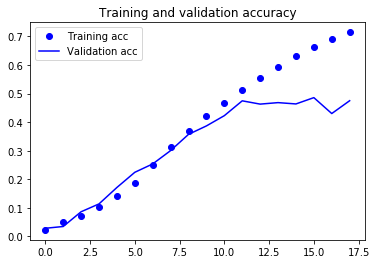

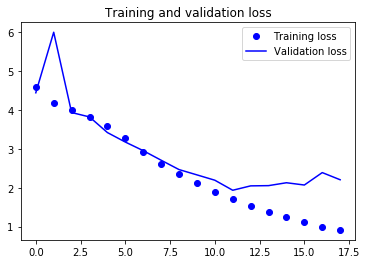

In [14]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.jet):
    """
    This function prints and plots the confusion matrix.
    """
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [24]:
model = load_model('/content/drive/My Drive/Colab Notebooks/inception resnet model.hdf5')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [0]:
import numpy as np
from sklearn.metrics import confusion_matrix

Y_pred = model.predict(testX)
y_pred1 = np.argmax(Y_pred, axis=1)
testY1 = np.argmax(testY, axis=1)


In [0]:
plt.figure(num=None, figsize=(10, 10), dpi=200, facecolor='w', edgecolor='k')

classes = []
for i in range(0,99):
  classes.append(i)

plot_confusion_matrix(confusion_matrix(y_pred1,testY1),classes)
plt.savefig('plt.png')

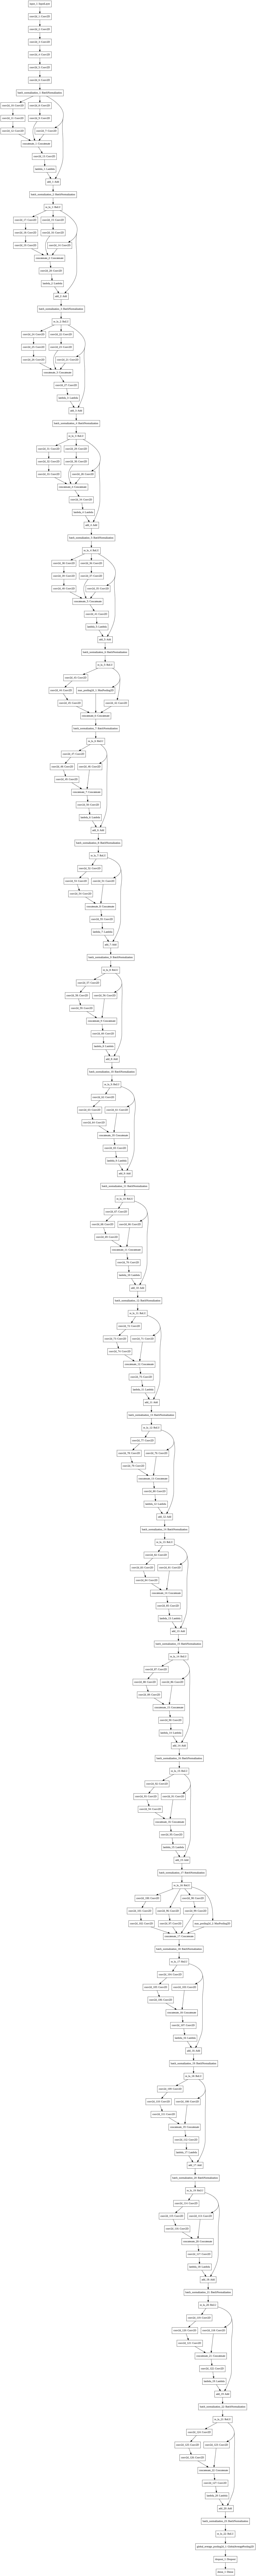

In [17]:
plot_model(model, 'inception_resnet_model_plot.png')